# Multi-label classification of research articles
<a target="_blank" href="https://colab.research.google.com/github/SrjPdl/multi-label-article-classification-bert">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook tries to fine-tune BERT for multi-label classification of research articles. The dataset used is the taken from [Janatahack NLP Topic Modeling](https://www.kaggle.com/code/venkatkrishnan/81-5-janatahack-nlp-topic-modeling/input?select=train.csv) from Kaggle. The dataset contains title and abstract of research articles and the task is to predict the topics associated with the article.

## Download the dataset

In [ ]:
!gdown 1B4myXuHfdsugaaRqI9KZhAErbB_EWTod

Downloading...
From: https://drive.google.com/uc?id=1B4myXuHfdsugaaRqI9KZhAErbB_EWTod
To: /content/multi_label_text.csv
100% 23.2M/23.2M [00:00<00:00, 43.7MB/s]


## Installing the HuggingFace transformers library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.9 MB/s eta 0:00:00


## Importing the libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
import os

In [ ]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the dataset

In [ ]:
clf_data = pd.read_csv("/content/multi_label_text.csv")
clf_data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
print(f"There are {len(clf_data)} articles in the dataset.")

There are 20972 articles in the dataset.


## Reviewing the distribution of labels in the dataset

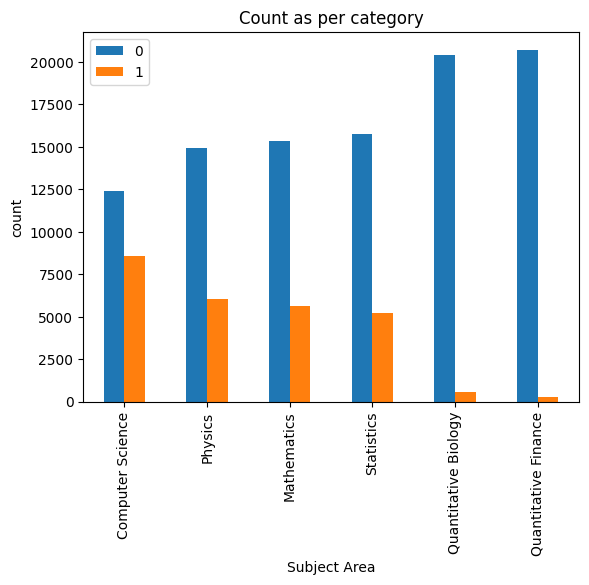

In [ ]:
cs = clf_data['Computer Science'].value_counts()
phy = clf_data['Physics'].value_counts()
mat = clf_data['Mathematics'].value_counts()
stat = clf_data['Statistics'].value_counts()
qb = clf_data['Quantitative Biology'].value_counts()
qf = clf_data['Quantitative Finance'].value_counts()

df = pd.DataFrame([cs, phy, mat, stat, qb, qf])
df.plot(kind = "bar" )
plt.title("Count as per category")
plt.xlabel("Subject Area")
plt.ylabel("count");

## Combining title and abstract

In [ ]:
clf_data.insert(0, 'combined', clf_data['TITLE'] + ". " + clf_data['ABSTRACT'])

In [ ]:
clf_data.drop(["ID", "TITLE", "ABSTRACT"], axis=1, inplace=True)

In [ ]:
clf_data.head()

,combined,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps. ...,1,0,0,0,0,0
1,Rotation Invariance Neural Network. Rotation...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


In [ ]:
clf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   combined              20972 non-null  object
 1   Computer Science      20972 non-null  int64 
 2   Physics               20972 non-null  int64 
 3   Mathematics           20972 non-null  int64 
 4   Statistics            20972 non-null  int64 
 5   Quantitative Biology  20972 non-null  int64 
 6   Quantitative Finance  20972 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


## Defining index to label mapping

In [ ]:
classes = [c for c in clf_data.columns if  clf_data[c].dtype =='int64']
idx_to_class = {i:c for i,c in enumerate(clf_data.columns) if  clf_data[c].dtype =='int64'}

In [ ]:
classes

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

In [ ]:
idx_to_class

{1: 'Computer Science',
 2: 'Physics',
 3: 'Mathematics',
 4: 'Statistics',
 5: 'Quantitative Biology',
 6: 'Quantitative Finance'}

In [ ]:
max_length_of_sentence = clf_data['combined'].str.len().max()
max_length_of_sentence

2862

## Training variables

In [ ]:
MAX_INPUT_LENGTH = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 16
LR = 1e-5
NUM_EPOCHS = 5

## Pretrained BERT tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

## Defining custom PyTorch dataset

In [ ]:
class ClfDataset(Dataset):
  def __init__(self, data, tokenizer, targets, max_length):
    self.data = data
    self.tokenizer = tokenizer
    self.text = self.data['combined']
    self.targets = self.data[targets].values
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    cur_text = " ".join(self.text[idx].split())
    inputs = self.tokenizer.encode_plus(
        cur_text,
        add_special_tokens = True,
        max_length = self.max_length,
        padding="max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt"
    )
    inputs['targets'] = torch.FloatTensor(self.targets[idx])
    return inputs

## Splitting the dataset into train, validation and test sets

In [ ]:
test_size = 0.2
valid_size = 0.1 # it is taken after splitting into train and test set
train_data, test_data = train_test_split(clf_data, shuffle=True, test_size=test_size)
train_data, valid_data = train_test_split(train_data, shuffle=True, test_size=valid_size)

train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_dataset = ClfDataset(train_data, tokenizer, classes, MAX_INPUT_LENGTH)
test_dataset = ClfDataset(test_data, tokenizer, classes, MAX_INPUT_LENGTH)
valid_dataset = ClfDataset(valid_data, tokenizer, classes, MAX_INPUT_LENGTH)

train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, shuffle=True, num_workers = 2)
valid_data_loader = DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers = 2)
test_data_loader = DataLoader(test_dataset, batch_size = TEST_BATCH_SIZE, num_workers = 2)

In [ ]:
train_data.head()

,combined,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Equipping weak equivalences with algebraic str...,0,0,1,0,0,0
1,Nematic phase with colossal magnetoresistance ...,0,1,0,0,0,0
2,Steinberg representations and harmonic cochain...,0,0,1,0,0,0
3,Semistable rank 2 sheaves with singularities o...,0,0,1,0,0,0
4,Newton-Type Methods for Non-Convex Optimizatio...,1,0,0,1,0,0


## Defining the model architecture

In [ ]:
class BERTClf(nn.Module):
  def __init__(self):
    super(BERTClf, self).__init__()
    self.bert_base = BertModel.from_pretrained("bert-base-uncased", return_dict = True)
    self.drop_out = nn.Dropout(0.2)
    self.linear = nn.Linear(768, 6)

  def forward(self, input_ids, attention_mask, token_type_ids):
    input_ids = input_ids.squeeze(0)
    attention_mask = attention_mask.squeeze(0)
    token_type_ids = token_type_ids.squeeze(0)
    x = self.bert_base(
        input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids
    )
    x = x.pooler_output
    x = self.drop_out(x)
    output = self.linear(x)
    return output

In [ ]:
model = BERTClf()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClf(
  (bert_base): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
def save_ckpt(state, is_best_model, ckpt_path, best_model_path):
  torch.save(state, ckpt_path)
  if is_best_model:
    shutil.copyfile(ckpt_path, best_model_path)

def load_ckpt(ckpt_path, model, optimizer):
  ckpt = torch.load(ckpt_path)
  model.load_state_dict(ckpt['state_dict'])
  optimizer.load_state_dict(ckpt['optimizer'])
  valid_loss_min = ckpt['valid_loss_min']
  return model, optimizer, ckpt['epoch'], valid_loss_min.item()

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

## Model training

In [ ]:
def train(num_epochs, loss_fn, optimizer, train_data_loader, valid_data_loader, ckpt_path, best_model_path, print_frequency):

  train_loss_epoch = []
  valid_loss_epoch = []
  best_val_loss = np.inf

  for epoch in range(num_epochs):
    print(f"\n*****EPOCH {epoch+1}*****\n")
    running_loss = 0.0

    model.train()
    for batch_idx, data in enumerate(train_data_loader):
      input_ids = data['input_ids'].to(device, dtype=torch.long).squeeze()
      token_type_ids = data['token_type_ids'].to(device, dtype=torch.long).squeeze()
      attention_mask = data['attention_mask'].to(device, dtype=torch.long).squeeze()
      targets = data['targets'].to(device, dtype=torch.float)

      outputs = model(input_ids, attention_mask, token_type_ids)
      loss = loss_fn(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      del data
      del input_ids
      del token_type_ids
      del attention_mask
      if device.type == "cuda":
        torch.cuda.empty_cache()

      if batch_idx % print_frequency == 0:
            print(f"  Batch {batch_idx+1}/{len(train_data_loader)} - Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_data_loader)
    train_loss_epoch.append(epoch_loss)
    print(f"  Epoch {epoch+1} - Average Train Loss: {epoch_loss:.4f}")

    #evaluate on validation set
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for data in valid_data_loader:
            input_ids = data['input_ids'].to(device, dtype=torch.long).squeeze()
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long).squeeze()
            attention_mask = data['attention_mask'].to(device, dtype=torch.long).squeeze()
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(input_ids, attention_mask, token_type_ids)
            valid_loss += loss_fn(outputs, targets)

            del data
            del input_ids
            del token_type_ids
            del attention_mask
            if device.type == "cuda":
              torch.cuda.empty_cache()

    valid_loss /= len(valid_data_loader)
    print(f"  Epoch {epoch+1} - Validation Loss: {valid_loss:.4f}")
    valid_loss_epoch.append(valid_loss)

    ckpt = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
            }
    ckpt_path_file = os.path.join(ckpt_path, f"model_epoch_{epoch+1}.pt")
    save_ckpt(ckpt, False, ckpt_path_file, best_model_path)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_name = os.path.join(best_model_path, f"best_model_epoch_{epoch+1}.pt")
        print(" Saving best model checkpoint")
        save_ckpt(ckpt, True, ckpt_path_file, best_model_name)

  return model, train_loss_epoch, valid_loss_epoch


In [ ]:
ckpt_path = "/content/checkpoints"
os.makedirs(ckpt_path, exist_ok = True)
best_model_path = "/content/best_model_checkpoint"
os.makedirs(best_model_path, exist_ok = True)
print_frequency = 100

In [ ]:
trained_model, train_loss_epoch, valid_loss_epoch = train(NUM_EPOCHS, loss_fn, optimizer, train_data_loader, valid_data_loader, ckpt_path, best_model_path, print_frequency)


*****EPOCH 1*****

  Batch 1/472 - Loss: 0.7149
  Batch 101/472 - Loss: 0.3663
  Batch 201/472 - Loss: 0.2602
  Batch 301/472 - Loss: 0.2353
  Batch 401/472 - Loss: 0.1606
  Epoch 1 - Average Train Loss: 0.2815
  Epoch 1 - Validation Loss: 0.2052
 Saving best model checkpoint

*****EPOCH 2*****

  Batch 1/472 - Loss: 0.2423
  Batch 101/472 - Loss: 0.2108
  Batch 201/472 - Loss: 0.1000
  Batch 301/472 - Loss: 0.1570
  Batch 401/472 - Loss: 0.1267
  Epoch 2 - Average Train Loss: 0.1810
  Epoch 2 - Validation Loss: 0.1739
 Saving best model checkpoint

*****EPOCH 3*****

  Batch 1/472 - Loss: 0.1205
  Batch 101/472 - Loss: 0.2085
  Batch 201/472 - Loss: 0.1205
  Batch 301/472 - Loss: 0.1544
  Batch 401/472 - Loss: 0.1422
  Epoch 3 - Average Train Loss: 0.1529
  Epoch 3 - Validation Loss: 0.1741

*****EPOCH 4*****

  Batch 1/472 - Loss: 0.1431
  Batch 101/472 - Loss: 0.1171
  Batch 201/472 - Loss: 0.1514
  Batch 301/472 - Loss: 0.1856
  Batch 401/472 - Loss: 0.0811
  Epoch 4 - Average Tra

In [ ]:
valid_loss_cpu = [torch.Tensor.cpu(valid_loss_epoch[i]).numpy() for i in range(len(valid_loss_epoch))]

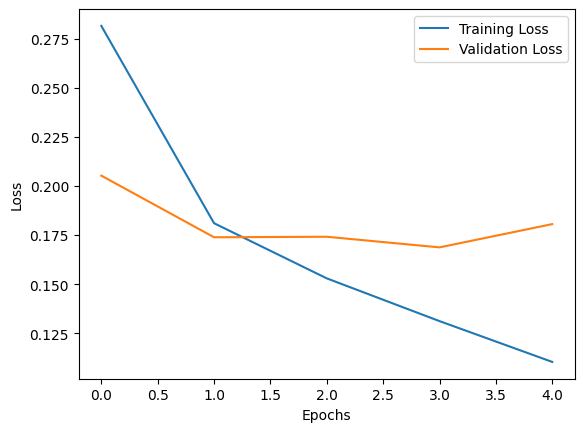

In [ ]:
plt.plot(train_loss_epoch, label="Training Loss")
plt.plot(valid_loss_cpu, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss");

## Previous best model

In [ ]:
# downloading previously trained model ckpt to prevent retraining every time
!gdown 1jkI54-_8t2lOe6_ziux6bdOq3uZBQRYc

Downloading...
From: https://drive.google.com/uc?id=1jkI54-_8t2lOe6_ziux6bdOq3uZBQRYc
To: /content/best_model_epoch_3.pt
100% 1.31G/1.31G [00:12<00:00, 106MB/s]


In [ ]:
trained_model, optimizer, epochs, val_loss_min = load_ckpt("/content/best_model_epoch_3.pt", model, optimizer)

In [ ]:
print(f"The loaded model was trained for {epochs} with min_valid_loss: {val_loss_min}")

The loaded model was trained for 3 with min_valid_loss: 0.1626671850681305


## Evaluating the model on the test set

In [ ]:
true_targets = []
pred_outputs = []
test_loss = 0.0
with torch.no_grad():
  for data in test_data_loader:
      input_ids = data['input_ids'].to(device, dtype=torch.long).squeeze()
      token_type_ids = data['token_type_ids'].to(device, dtype=torch.long).squeeze()
      attention_mask = data['attention_mask'].to(device, dtype=torch.long).squeeze()
      targets = data['targets'].to(device, dtype=torch.float)
      true_targets.append(targets)

      outputs = trained_model(input_ids, attention_mask, token_type_ids)
      pred_outputs.append(outputs)
      test_loss += loss_fn(outputs, targets)

      del data
      del input_ids
      del token_type_ids
      del attention_mask
      if device.type == "cuda":
        torch.cuda.empty_cache()
test_loss /= len(test_data_loader)
print(test_loss)

tensor(0.1366, device='cuda:0')


In [ ]:
for i, pred in enumerate(pred_outputs):
  pred_outputs[i] = torch.sigmoid(pred)

In [ ]:
threshold = 0.5
pred_out = pred_outputs[:]
act_out = true_targets[:]

In [ ]:
def to_cpu(x):
  return torch.Tensor.cpu(x)

def assign_label(x):
  return x>threshold

In [ ]:
pred_out = list(map(to_cpu, pred_out))
predicted_probabilities = np.concatenate([batch.view(-1, batch.shape[-1]).float().numpy() for batch in pred_out])
pred_out = list(map(assign_label, pred_out))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_curve, auc

In [ ]:
act_out = list(map(to_cpu, map(assign_label, act_out)))

In [ ]:
predicted_labels = np.concatenate([batch.view(-1, batch.shape[-1]).int().numpy() for batch in pred_out])
true_labels = np.concatenate([batch.view(-1, batch.shape[-1]).int().numpy() for batch in act_out])

### Confusion matrix

In [ ]:
confusion_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

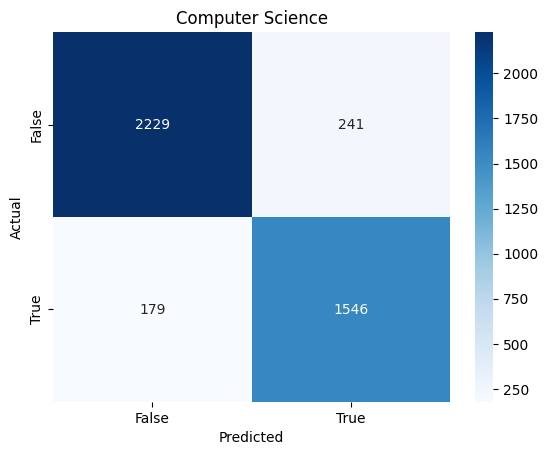

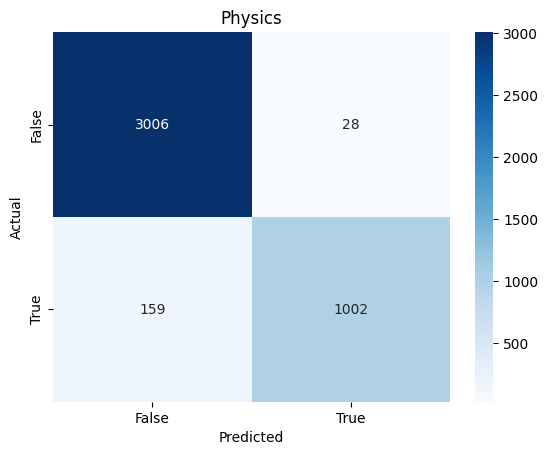

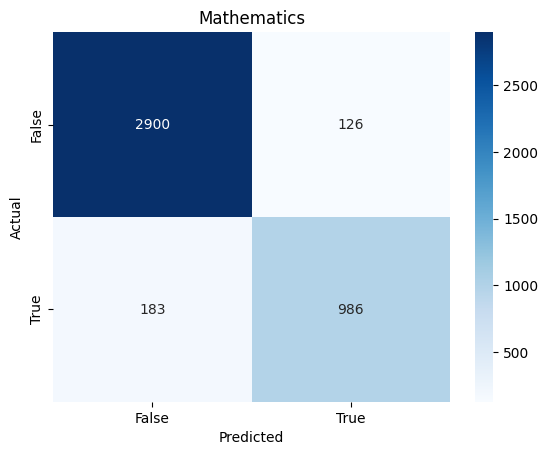

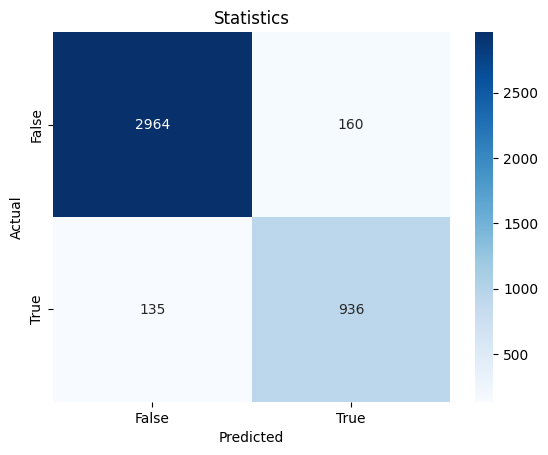

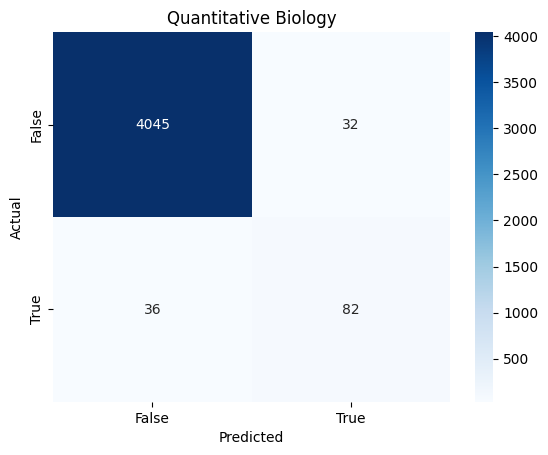

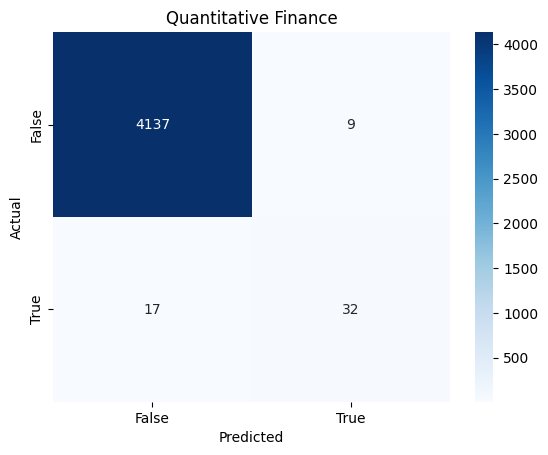

In [ ]:
num_labels = predicted_labels.shape[1]
for i in range(num_labels):
    tn, fp, fn, tp = confusion_matrix[i].ravel()
    labels = ['False', 'True']
    matrix = np.array([[tn, fp], [fn, tp]])
    ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(idx_to_class[i+1])
    plt.show()

### Classification report

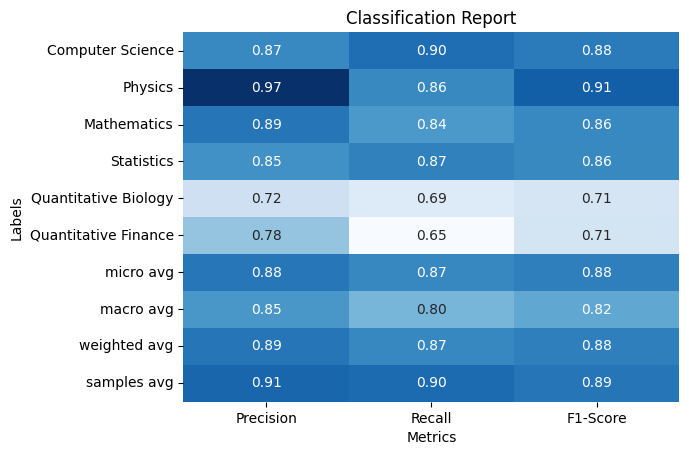

In [ ]:
report_dict = classification_report(true_labels, predicted_labels, target_names=classes, output_dict=True,  zero_division=0)
report_array = np.array([[report_dict[label]['precision'], report_dict[label]['recall'], report_dict[label]['f1-score']] for label in report_dict.keys()])

sns.heatmap(report_array, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=['Precision', 'Recall', 'F1-Score'], yticklabels=list(report_dict.keys()))
plt.xlabel('Metrics')
plt.ylabel('Labels')
plt.title('Classification Report')
plt.show()

### ROC curve

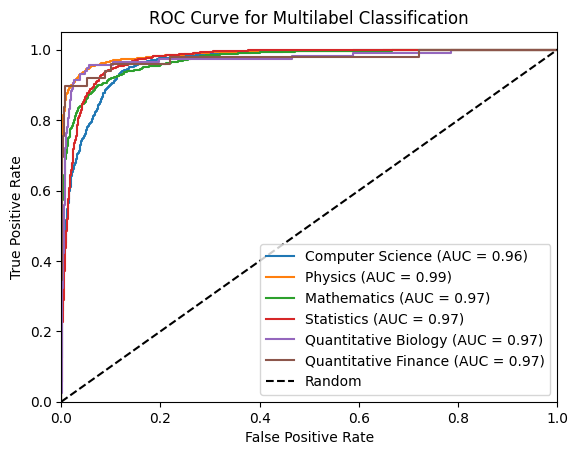

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
num_labels = true_labels.shape[1]
for i in range(num_labels):
    if np.sum(true_labels[:, i]) == 0:
        continue

    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_labels):
    if np.sum(true_labels[:, i]) == 0:
        continue

    plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(idx_to_class[i + 1], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc='lower right')
plt.show()

## Inference
Write anything you want in test_text variable below and run the cell.

In [ ]:
test_text = "Despite efforts to integrate research across different subdisciplines of biology, the scale of integration remains limited. We hypothesize that future generations of Artificial Intelligence (AI) technologies specifically adapted for biological sciences will help enable the reintegration of biology."

with torch.no_grad():
  inputs = tokenizer.encode_plus(
          test_text,
          add_special_tokens = True,
          max_length = MAX_INPUT_LENGTH,
          padding="max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"
      )
  input_ids = inputs['input_ids'].unsqueeze(0).to(device)
  attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
  token_type_ids = inputs['token_type_ids'].unsqueeze(0).to(device)
  model.eval()
  pred = trained_model(input_ids, attention_mask, token_type_ids)

print("Predicted Scores: ")
pred = torch.sigmoid(pred)
print(" ", pred)
pred = pred>threshold
print("\nPredicted Classes: ")
for i,p in enumerate(pred[0]):
  if p:
    print(" ",idx_to_class[i+1])

Predicted Scores: 
  tensor([[0.5498, 0.0992, 0.0183, 0.1884, 0.5075, 0.0175]], device='cuda:0')

Predicted Classes: 
  Computer Science
  Quantitative Biology
